<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimization-Algorithms" data-toc-modified-id="Optimization-Algorithms-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimization Algorithms</a></span><ul class="toc-item"><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Gradient Descent</a></span></li><li><span><a href="#MiniBatch-Gradient-Descent" data-toc-modified-id="MiniBatch-Gradient-Descent-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MiniBatch Gradient Descent</a></span></li><li><span><a href="#Momentum" data-toc-modified-id="Momentum-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Momentum</a></span></li><li><span><a href="#Adam" data-toc-modified-id="Adam-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Adam</a></span></li></ul></li><li><span><a href="#Models-with-different-optimization-algorithms" data-toc-modified-id="Models-with-different-optimization-algorithms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models with different optimization algorithms</a></span><ul class="toc-item"><li><span><a href="#MiniBatch-Gradient-Descent" data-toc-modified-id="MiniBatch-Gradient-Descent-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>MiniBatch Gradient Descent</a></span></li><li><span><a href="#MiniBatch-Gradient-Descent-with-Momentum" data-toc-modified-id="MiniBatch-Gradient-Descent-with-Momentum-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>MiniBatch Gradient Descent with Momentum</a></span></li><li><span><a href="#MiniBatch-with-Adam-Optimizer" data-toc-modified-id="MiniBatch-with-Adam-Optimizer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>MiniBatch with Adam Optimizer</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#5.4---Summary" data-toc-modified-id="5.4---Summary-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>5.4 - Summary</a></span></li></ul></li></ul></div>

# Optimization Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
from deeplearning.course_two.optimization.opt_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Optimization Algorithms

### Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent.

In [11]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads['db' + str(l+1)]  
    return parameters

### MiniBatch Gradient Descent

In [2]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]   
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)* mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)* mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

### Momentum

In [3]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 
    v = {}
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
    return v

In [4]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)]+(1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)]+(1-beta)*grads['db' + str(l+1)]
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v["db" + str(l+1)]
    return parameters, v

### Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

In [5]:
def initialize_adam(parameters) :
    L = len(parameters) // 2
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
    return v, s

In [6]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}    
    s_corrected = {}    

    for l in range(L):

        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1-beta1**t)

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*(grads["dW" + str(l+1)])**2
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*(grads["db" + str(l+1)])**2

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1-beta2**t)

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

## Models with different optimization algorithms

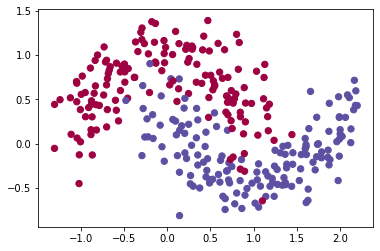

In [7]:
train_X, train_Y = load_dataset()

In [9]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)
    costs = []      
    t = 0           
    seed = 10         
    parameters = initialize_parameters(layers_dims)

    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return parameters

### MiniBatch Gradient Descent

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


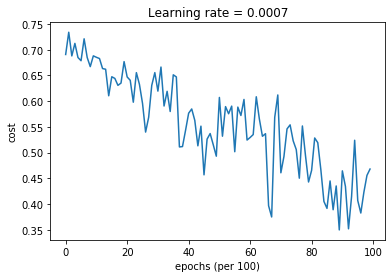

Accuracy: 0.7966666666666666


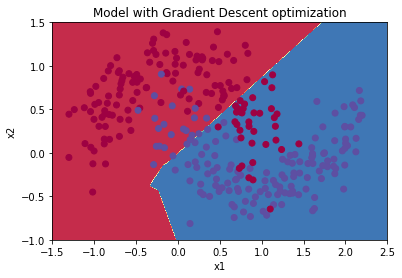

In [12]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### MiniBatch Gradient Descent with Momentum

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


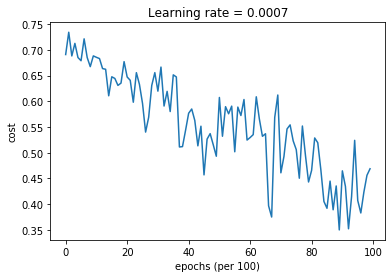

Accuracy: 0.7966666666666666


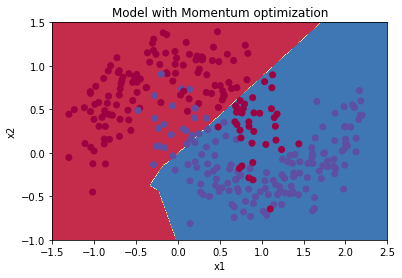

In [13]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### MiniBatch with Adam Optimizer

Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185567
Cost after epoch 2000: 0.150852
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125936
Cost after epoch 5000: 0.104235
Cost after epoch 6000: 0.100552
Cost after epoch 7000: 0.031601
Cost after epoch 8000: 0.111709
Cost after epoch 9000: 0.197648


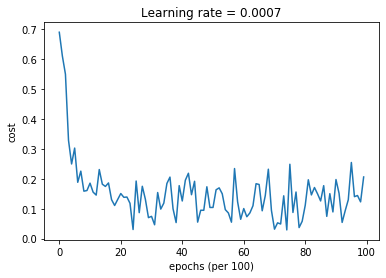

Accuracy: 0.94


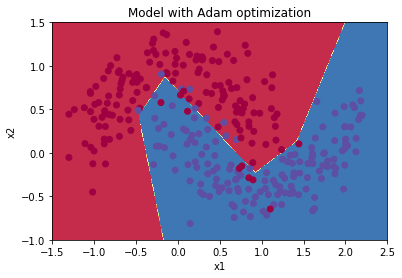

In [14]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Summary

### 5.4 - Summary

<table> 
    <tr>
        <td>
        **optimization method**
        </td>
        <td>
        **accuracy**
        </td>
        <td>
        **cost shape**
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)